In [0]:
# import necessary libraries
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import torch
import numpy as np
import cv2

In [0]:
from __future__ import print_function

from collections import defaultdict, deque
import datetime
import pickle
import time
import torch.distributed as dist
import errno

import collections
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image, ImageFile
import pandas as pd
from tqdm import tqdm
from torchvision import transforms
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

ImageFile.LOAD_TRUNCATED_IMAGES = True

# Tools

In [0]:
### cite https://www.kaggle.com/abhishek/train-your-own-mask-rcnn

class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)


def all_gather(data):
    """
    Run all_gather on arbitrary picklable data (not necessarily tensors)
    Args:
        data: any picklable object
    Returns:
        list[data]: list of data gathered from each rank
    """
    world_size = get_world_size()
    if world_size == 1:
        return [data]

    # serialized to a Tensor
    buffer = pickle.dumps(data)
    storage = torch.ByteStorage.from_buffer(buffer)
    tensor = torch.ByteTensor(storage).to("cuda")

    # obtain Tensor size of each rank
    local_size = torch.tensor([tensor.numel()], device="cuda")
    size_list = [torch.tensor([0], device="cuda") for _ in range(world_size)]
    dist.all_gather(size_list, local_size)
    size_list = [int(size.item()) for size in size_list]
    max_size = max(size_list)

    # receiving Tensor from all ranks
    # we pad the tensor because torch all_gather does not support
    # gathering tensors of different shapes
    tensor_list = []
    for _ in size_list:
        tensor_list.append(torch.empty((max_size,), dtype=torch.uint8, device="cuda"))
    if local_size != max_size:
        padding = torch.empty(size=(max_size - local_size,), dtype=torch.uint8, device="cuda")
        tensor = torch.cat((tensor, padding), dim=0)
    dist.all_gather(tensor_list, tensor)

    data_list = []
    for size, tensor in zip(size_list, tensor_list):
        buffer = tensor.cpu().numpy().tobytes()[:size]
        data_list.append(pickle.loads(buffer))

    return data_list


def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.no_grad():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict


class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        log_msg = self.delimiter.join([
            header,
            '[{0' + space_fmt + '}/{1}]',
            'eta: {eta}',
            '{meters}',
            'time: {time}',
            'data: {data}',
            'max mem: {memory:.0f}'
        ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                print(log_msg.format(
                    i, len(iterable), eta=eta_string,
                    meters=str(self),
                    time=str(iter_time), data=str(data_time),
                    memory=torch.cuda.max_memory_allocated() / MB))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.4f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))


def collate_fn(batch):
    return tuple(zip(*batch))


def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):

    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)


def mkdir(path):
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise


def setup_for_distributed(is_master):
    """
    This function disables printing when not in master process
    """
    import builtins as __builtin__
    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        force = kwargs.pop('force', False)
        if is_master or force:
            builtin_print(*args, **kwargs)

    __builtin__.print = print


def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()


def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()


def is_main_process():
    return get_rank() == 0


def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)


def init_distributed_mode(args):
    if 'RANK' in os.environ and 'WORLD_SIZE' in os.environ:
        args.rank = int(os.environ["RANK"])
        args.world_size = int(os.environ['WORLD_SIZE'])
        args.gpu = int(os.environ['LOCAL_RANK'])
    elif 'SLURM_PROCID' in os.environ:
        args.rank = int(os.environ['SLURM_PROCID'])
        args.gpu = args.rank % torch.cuda.device_count()
    else:
        print('Not using distributed mode')
        args.distributed = False
        return

    args.distributed = True

    torch.cuda.set_device(args.gpu)
    args.dist_backend = 'nccl'
    print('| distributed init (rank {}): {}'.format(
        args.rank, args.dist_url), flush=True)
    torch.distributed.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                                         world_size=args.world_size, rank=args.rank)
    torch.distributed.barrier()
    setup_for_distributed(args.rank == 0)

In [0]:
### cite https://www.kaggle.com/abhishek/train-your-own-mask-rcnn
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

In [125]:
# Pretrained model from torchvision

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 3
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.eval()
model.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

In [0]:
for param in model.parameters():
    param.requires_grad = True

Load Data

In [84]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
# category 1-uninfected 2-infected 0-background
train= pd.read_csv ('/content/drive/My Drive/Colab Notebooks/Data/train/train_df.csv')
train['category'][train['category']=='uninfected']=1
train['category'][train['category']=='infected']=2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [86]:
test= pd.read_csv ('/content/drive/My Drive/Colab Notebooks/Data/test/test_df.csv')
test['category'][test['category']=='uninfected']=1
test['category'][test['category']=='infected']=2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
train['path'] = train['path'].map(lambda x: x.replace('\\','/').replace('..','/content/drive/My Drive/Colab Notebooks'))

In [0]:
test['path'] = test['path'].map(lambda x: x.replace('\\','/').replace('..','/content/drive/My Drive/Colab Notebooks'))

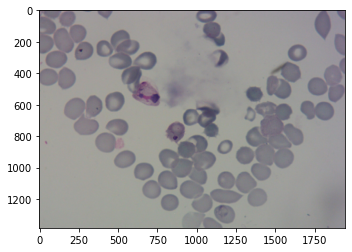

In [0]:
image = plt.imread(test['path'][0])
plt.imshow(image)

In [0]:
train_2 = pd.DataFrame(columns=('path','labels','boxes'))
for i in train['path'].unique():
    df_i = train[train['path']==i]
    labels = []
    boxes = []
    for j in df_i.index:
        labels.append(df_i['category'][j])
        boxes.append([df_i['x1'][j],df_i['y1'][j],df_i['x2'][j],df_i['y2'][j]])
    train_2 = train_2.append(pd.DataFrame({
        'path':[i],
        'labels':[labels],
        'boxes':[boxes]
    }),ignore_index=True)

In [0]:
test_2 = pd.DataFrame(columns=('path','labels','boxes'))
for i in test['path'].unique():
    df_i = test[test['path']==i]
    labels = []
    boxes = []
    for j in df_i.index:
        labels.append(df_i['category'][j])
        boxes.append([df_i['x1'][j],df_i['y1'][j],df_i['x2'][j],df_i['y2'][j]])
    test_2 = test_2.append(pd.DataFrame({
        'path':[i],
        'labels':[labels],
        'boxes':[boxes]
    }),ignore_index=True)

In [115]:
train_2.head()

,path,labels,boxes
0,/content/drive/My Drive/Colab Notebooks/malari...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[1440, 1057, 1540, 1158], [1303, 868, 1403, 9..."
1,/content/drive/My Drive/Colab Notebooks/malari...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[735, 734, 834, 832], [1283, 939, 1378, 1039]..."
2,/content/drive/My Drive/Colab Notebooks/malari...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[1027, 724, 1136, 834], [1155, 287, 1254, 387..."
3,/content/drive/My Drive/Colab Notebooks/malari...,"[1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[1421, 563, 1545, 656], [324, 208, 446, 337],..."
4,/content/drive/My Drive/Colab Notebooks/malari...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[688, 618, 810, 744], [1035, 689, 1168, 819],..."


In [0]:
class MalariaDataset(torch.utils.data.Dataset):
    

    def __init__(self, df, img_dir): #df = train #img_dir = '../malaria/images/'
        self.df = df
        self.height = 256
        self.width = 256
        self.img_dir = img_dir
        
#         self.y = self.df['labels']
        
    def __getitem__(self, idx):
        #resize the images(256x256)
        img = Image.open(self.df['path'][idx])
        width, height = img.size
        img = img.resize((self.width, self.height), resample=Image.BILINEAR)
                
        boxes = torch.as_tensor(self.df['boxes'][idx], dtype=torch.float32)
        # resize the boxes along with the images(256x256)
        for i in range(len(boxes)):
            boxes[i][0] = boxes[i][0]/(width/self.width)
            boxes[i][1] = boxes[i][1]/(height/self.width)
            boxes[i][2] = boxes[i][2]/(width/self.width)
            boxes[i][3] = boxes[i][3]/(height/self.width)
        labels = torch.as_tensor((self.df['labels'][idx]), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.tensor([0])  
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd


        return transforms.ToTensor()(img), target

    def __len__(self):
        return len(self.df)

In [0]:
dataset_train = MalariaDataset(train_2, '/content/drive/My Drive/Colab Notebooks/malaria/images/')

In [0]:
dataset_test = MalariaDataset(test_2, '/content/drive/My Drive/Colab Notebooks/malaria/images/')

test whether the MalariaDataset function works

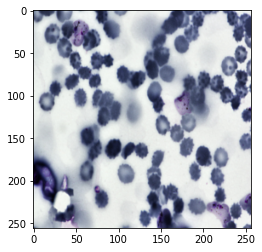

In [145]:
plt.imshow(dataset_train.__getitem__(0)[0].permute(1, 2, 0))

First train image with its true boxes and labels

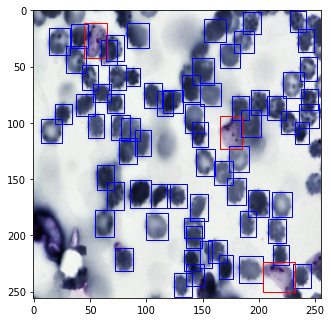

In [171]:
# first train image with its true boxes and labels

fig = plt.figure()

ax = fig.add_axes([0,0,1,1])

image = plt.imshow(dataset_train.__getitem__(0)[0].permute(1, 2, 0))

box_lab = dataset_train.__getitem__(0)[1]
for i in range(box_lab['boxes'].shape[0]):

    xmin = box_lab['boxes'][i][0]
    xmax = box_lab['boxes'][i][2]
    ymin = box_lab['boxes'][i][1]
    ymax = box_lab['boxes'][i][3]

    wid = xmax - xmin
    hei = ymax - ymin
    
    if box_lab['labels'][i] == 2:
        edgecolor = 'r'
    elif box_lab['labels'][i] == 1:
        edgecolor = 'b'

    rect = patches.Rectangle((xmin,ymin), wid, hei, edgecolor = edgecolor, facecolor = 'none')
    
    ax.add_patch(rect)

In [119]:
len(dataset_train)

1208

In [0]:
data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=lambda x: tuple(zip(*x)))

In [0]:
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=lambda x: tuple(zip(*x)))

Define Training Parameters

In [0]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=5,
                                               gamma=0.1)

In [0]:
# device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [178]:
num_epochs = 10
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    lr_scheduler.step()

Epoch: [0]  [  0/302]  eta: 0:09:53  lr: 0.000002  loss: 3.1056 (3.1056)  loss_classifier: 0.9280 (0.9280)  loss_box_reg: 0.3916 (0.3916)  loss_objectness: 1.6834 (1.6834)  loss_rpn_box_reg: 0.1026 (0.1026)  time: 1.9645  data: 1.2371  max mem: 10179
Epoch: [0]  [100/302]  eta: 0:01:50  lr: 0.000168  loss: 0.6817 (1.2223)  loss_classifier: 0.2809 (0.5180)  loss_box_reg: 0.2899 (0.3753)  loss_objectness: 0.0193 (0.2358)  loss_rpn_box_reg: 0.0859 (0.0933)  time: 0.5342  data: 0.0172  max mem: 10179
Epoch: [0]  [200/302]  eta: 0:00:55  lr: 0.000334  loss: 0.3903 (0.8633)  loss_classifier: 0.1857 (0.3701)  loss_box_reg: 0.1335 (0.2823)  loss_objectness: 0.0126 (0.1271)  loss_rpn_box_reg: 0.0663 (0.0839)  time: 0.5292  data: 0.0167  max mem: 10179
Epoch: [0]  [300/302]  eta: 0:00:01  lr: 0.000500  loss: 0.3532 (0.6999)  loss_classifier: 0.1617 (0.3056)  loss_box_reg: 0.1073 (0.2263)  loss_objectness: 0.0108 (0.0885)  loss_rpn_box_reg: 0.0699 (0.0794)  time: 0.5267  data: 0.0157  max mem: 10

In [0]:
torch.save(model.state_dict(), "model.bin")

In [0]:
torch.save(model,'/content/drive/My Drive/Colab Notebooks/faster.pt')

In [0]:
# model = torch.load('/content/drive/My Drive/Colab Notebooks/faster.pt')

In [0]:
# cite :https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = MetricLogger(delimiter="  ")
    header = 'Test:'

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for image, targets in metric_logger.log_every(data_loader, 100, header):
        image = list(img.to(device) for img in image)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(image)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator

In [0]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 7793, done.
remote: Total 7793 (delta 0), reused 0 (delta 0), pack-reused 7793
Receiving objects: 100% (7793/7793), 10.05 MiB | 9.35 MiB/s, done.
Resolving deltas: 100% (5326/5326), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


In [0]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [1]:

# evaluate(model, data_loader_test, device=device)
# does not work

### Predict one test image using the trained model

In [0]:
img_path = test_2['path'][0]

In [0]:
img = Image.open(img_path)
img = img.resize((256, 256), resample=Image.BILINEAR)
img = transforms.ToTensor()(img)

In [0]:
model.eval()
with torch.no_grad():
    pred = model([img.to(device)])

In [0]:
cell = ['background','uninfected','infected']

In [0]:
threshold = 0.8
pred_class = [cell[i] for i in list(pred[0]['labels'])]
pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach())]
pred_score = list(pred[0]['scores'].detach())
pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
pred_boxes = pred_boxes[:pred_t+1]
pred_class = pred_class[:pred_t+1]
pred_score = pred_score[:pred_t+1]


In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib import patches

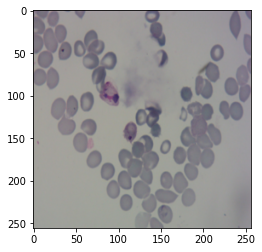

In [247]:
plt.imshow(img.permute(1, 2, 0))

In [0]:
import tensorflow as tf

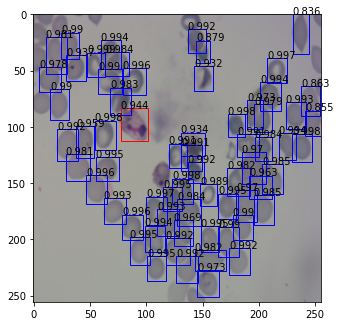

In [283]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])

image = plt.imshow(img.permute(1, 2, 0))


# box_lab = dataset_train.__getitem__(0)[1]
for i in range(len(pred_boxes)):

    xmin = pred_boxes[i][0][0]
    xmax = pred_boxes[i][1][0]
    ymin = pred_boxes[i][0][1]
    ymax = pred_boxes[i][1][1]

    wid = xmax - xmin
    hei = ymax - ymin
    
    if pred_class[i] == 'infected':
        edgecolor = 'r'
    elif pred_class[i] == 'uninfected':
        edgecolor = 'b'

    rect = patches.Rectangle((xmin,ymin), wid, hei, edgecolor = edgecolor, facecolor = 'none')
    
    ax.add_patch(rect)
    ax.text(xmin,ymin,pred_score[i].cpu().numpy().round(3).astype('str'))